In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import holidays

In [3]:
demand_df = pd.read_csv("data/demand_data.csv")
temp_df = pd.read_csv("data/temperature_data.csv")

In [4]:
df = temp_df.merge(demand_df, how="left", on=["Date"])
df = df.drop_duplicates(subset = "Date")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date").reset_index(drop=True)

In [5]:
data = df.copy()

In [6]:
""" Data Quality Checks """

#df.info()
#df.describe()
#df.isna().sum()
#df['Date'].diff().value_counts().head()


' Data Quality Checks '

# Basic EDA

## Temp x Demand

In [7]:
df = data.copy()
df['Hour'] = df['Date'].dt.hour + df['Date'].dt.minute / 60
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Monday
df['Month'] = df['Date'].dt.month

In [8]:
df[['Temperature', 'Demand']].corr()

,Temperature,Demand
Temperature,1.000000,0.304398
Demand,0.304398,1.000000


In [9]:
df['demand_detrended'] = df['Demand'] - df.groupby('Hour')['Demand'].transform('mean')
df['temp_detrended'] = df['Temperature'] - df.groupby('Hour')['Temperature'].transform('mean')
df[['demand_detrended', 'temp_detrended']].corr()


,demand_detrended,temp_detrended
demand_detrended,1.000000,0.522796
temp_detrended,0.522796,1.000000


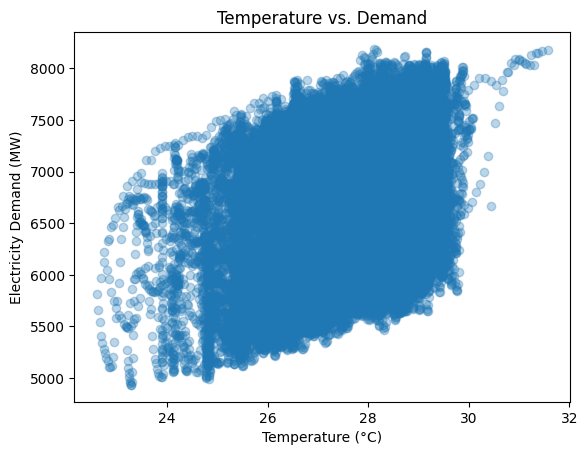

In [10]:
plt.scatter(df['Temperature'], df['Demand'], alpha=0.3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Electricity Demand (MW)")
plt.title("Temperature vs. Demand")
plt.show()


## Date x Demand

For things w/o linearity, try regression to see importance

In [11]:
df = data.copy()
df['Hour'] = df['Date'].dt.hour
df['DayOfWeek'] = df['Date'].dt.dayofweek   
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DateOnly'] = df['Date'].dt.date

# sg holidays
years = df['Date'].dt.year.unique()
sg_holidays = holidays.Singapore(years=years)

# Holiday flag
df['IsHoliday'] = df['DateOnly'].isin(sg_holidays).astype(int)
# Weekend flag
df['IsWeekend'] = df['Date'].dt.dayofweek.isin([5,6]).astype(int)

In [12]:
#df = pd.get_dummies(df, columns=['DayOfWeek'], drop_first=True)
#df = pd.get_dummies(df, columns=['Month'], drop_first=True)

df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24) # according to plot, follows -sin wave
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12) # according to plot, follow -cos wave

In [13]:
# Predictors
X = df[['Temperature', 'Hour_sin', 'Month_cos', 'IsWeekend', 'IsHoliday']]
# Dependent variable
y = df['Demand']
# Add constant for intercept
X = sm.add_constant(X)
# Regress
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                 1.194e+04
Date:                Sat, 25 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:27:42   Log-Likelihood:            -3.6011e+05
No. Observations:               48048   AIC:                         7.202e+05
Df Residuals:                   48042   BIC:                         7.203e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2798.7447     57.190     48.938      

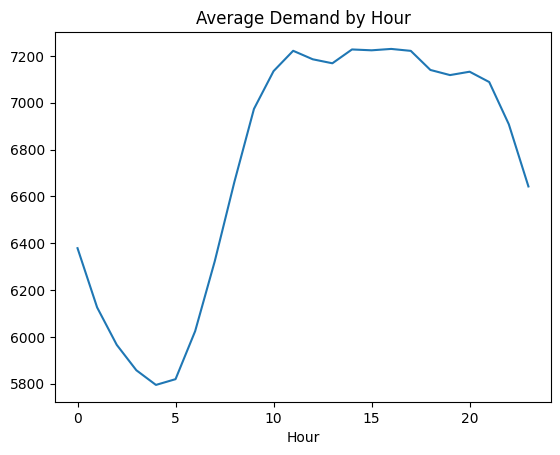

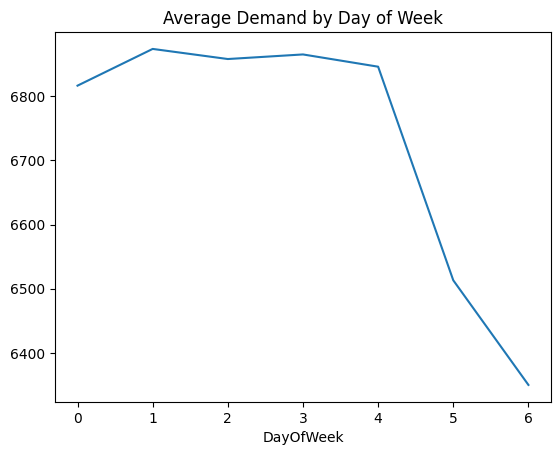

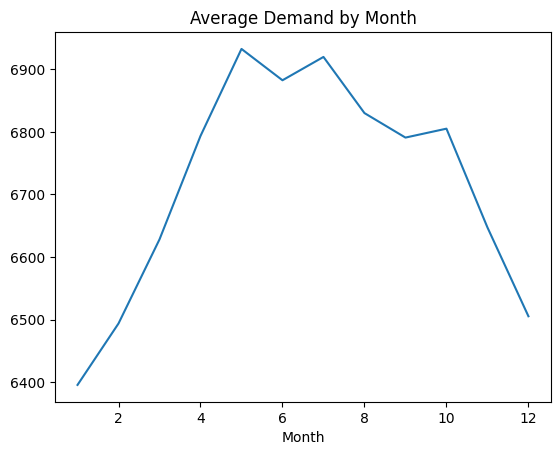

In [14]:
df.groupby('Hour')['Demand'].mean().plot(title='Average Demand by Hour')
plt.show()

df.groupby('DayOfWeek')['Demand'].mean().plot(title='Average Demand by Day of Week')
plt.show()

df.groupby('Month')['Demand'].mean().plot(title='Average Demand by Month')
plt.show()

In [15]:
df

,Date,Temperature,Demand,Hour,DayOfWeek,Month,Year,DateOnly,IsHoliday,IsWeekend,Hour_sin,Month_cos
0,2023-01-16 00:00:00,26.459149,6193.277465,0,0,1,2023,2023-01-16,0,0,0.000000,0.866025
1,2023-01-16 00:30:00,26.461370,6025.890821,0,0,1,2023,2023-01-16,0,0,0.000000,0.866025
2,2023-01-16 01:00:00,26.463591,5897.082365,1,0,1,2023,2023-01-16,0,0,0.258819,0.866025
3,2023-01-16 01:30:00,26.465813,5788.104071,1,0,1,2023,2023-01-16,0,0,0.258819,0.866025
4,2023-01-16 02:00:00,26.468034,5709.413524,2,0,1,2023,2023-01-16,0,0,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
48043,2025-10-12 21:30:00,27.836661,7168.846500,21,6,10,2025,2025-10-12,0,1,-0.707107,0.500000
48044,2025-10-12 22:00:00,27.825650,7108.270700,22,6,10,2025,2025-10-12,0,1,-0.500000,0.500000
48045,2025-10-12 22:30:00,27.814639,6973.176700,22,6,10,2025,2025-10-12,0,1,-0.500000,0.500000
48046,2025-10-12 23:00:00,27.803629,6847.095100,23,6,10,2025,2025-10-12,0,1,-0.258819,0.500000


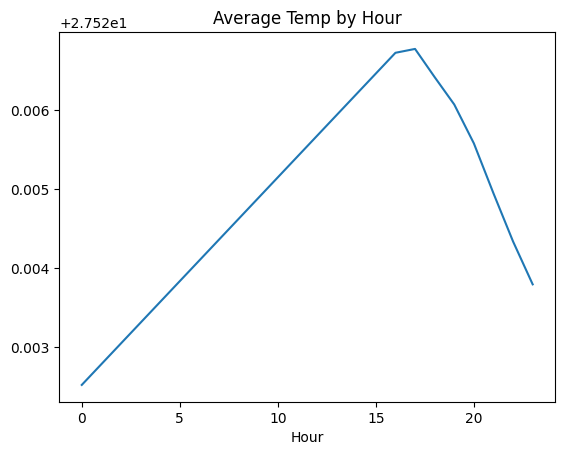

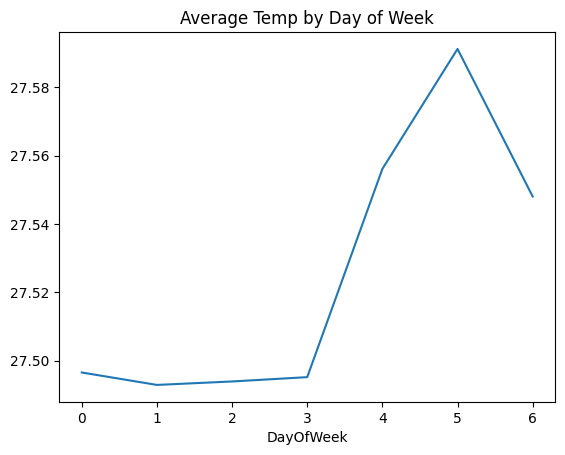

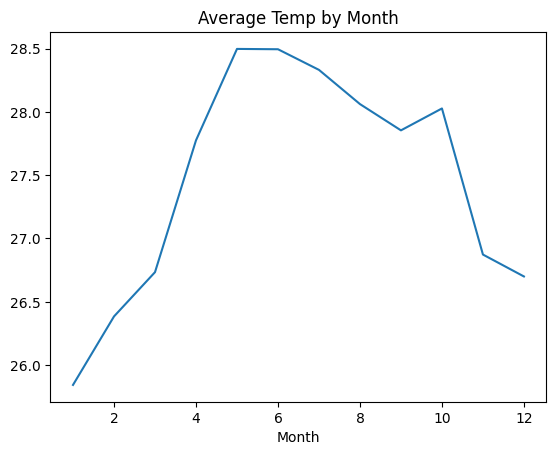

In [16]:
df.groupby('Hour')['Temperature'].mean().plot(title='Average Temp by Hour')
plt.show()

df.groupby('DayOfWeek')['Temperature'].mean().plot(title='Average Temp by Day of Week')
plt.show()

df.groupby('Month')['Temperature'].mean().plot(title='Average Temp by Month')
plt.show()

# Possible Breakers

## EVs x Demand

In [33]:
ev_data = pd.DataFrame({
    "Year": [2021, 2022, 2023, 2024, 2025],
    "EV Count": [2942, 6531, 11941, 26225, 38666]
})

ev_data


,Year,EV Count
0,2021,2942
1,2022,6531
2,2023,11941
3,2024,26225
4,2025,38666


In [18]:
df = demand_df.copy()

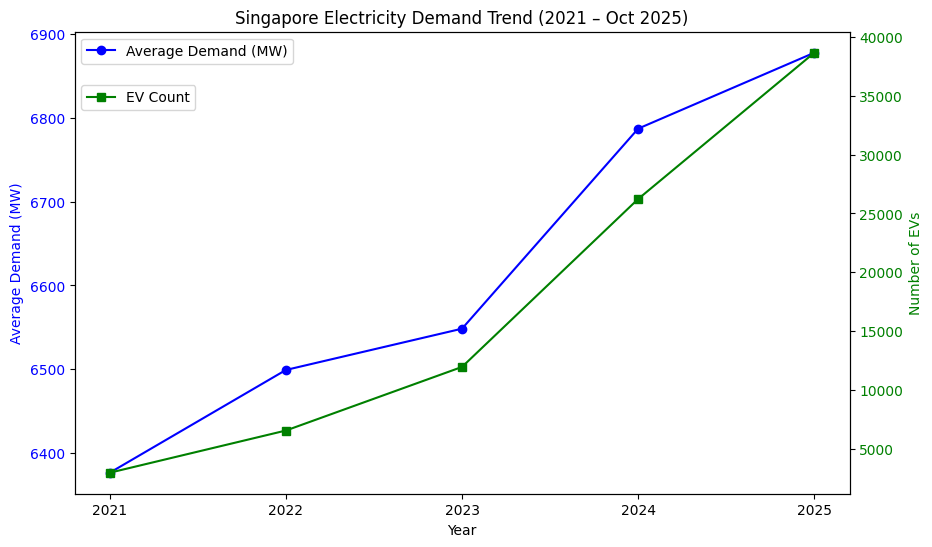

In [34]:
# Make sure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate by year (mean demand)
df['Year'] = df['Date'].dt.year
annual_demand = df.groupby('Year')['Demand'].mean().reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(annual_demand['Year'], annual_demand['Demand'], marker='o', color='blue', label='Average Demand (MW)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Demand (MW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Singapore Electricity Demand Trend (2021 – Oct 2025)')

# show only integer year labels
ax1.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# overlay EV adoption on secondary axis
ax2 = ax1.twinx()
ax2.plot(ev_data['Year'], ev_data['EV Count'], marker='s', color='green', label='EV Count')
ax2.set_ylabel('Number of EVs', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Legends
ax1.legend(loc='upper left', bbox_to_anchor=(0,1))
ax2.legend(loc='upper left', bbox_to_anchor=(0,0.9))

plt.show()


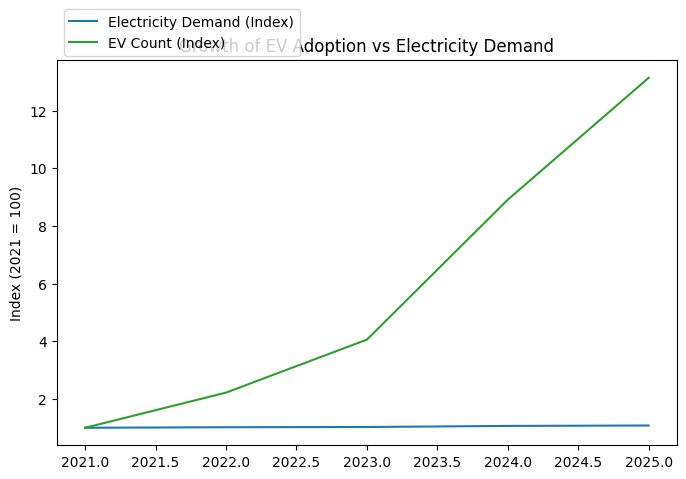

In [38]:
df_yearly = pd.merge(left=annual_demand, right=ev_data, on="Year")
df_plot = df_yearly.copy()
df_plot['Demand Growth'] = df_plot['Demand'] / df_plot['Demand'].iloc[0]
df_plot['EV Growth'] = df_plot['EV Count'] / df_plot['EV Count'].iloc[0]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df_plot['Year'], df_plot['Demand Growth'], label='Electricity Demand (Index)', color='tab:blue')
ax.plot(df_plot['Year'], df_plot['EV Growth'], label='EV Count (Index)', color='tab:green')
ax.set_ylabel("Index (2021 = 100)")
ax.set_title("Growth of EV Adoption vs Electricity Demand")
ax.legend(loc='upper left', bbox_to_anchor=(0,1.15))
plt.show()

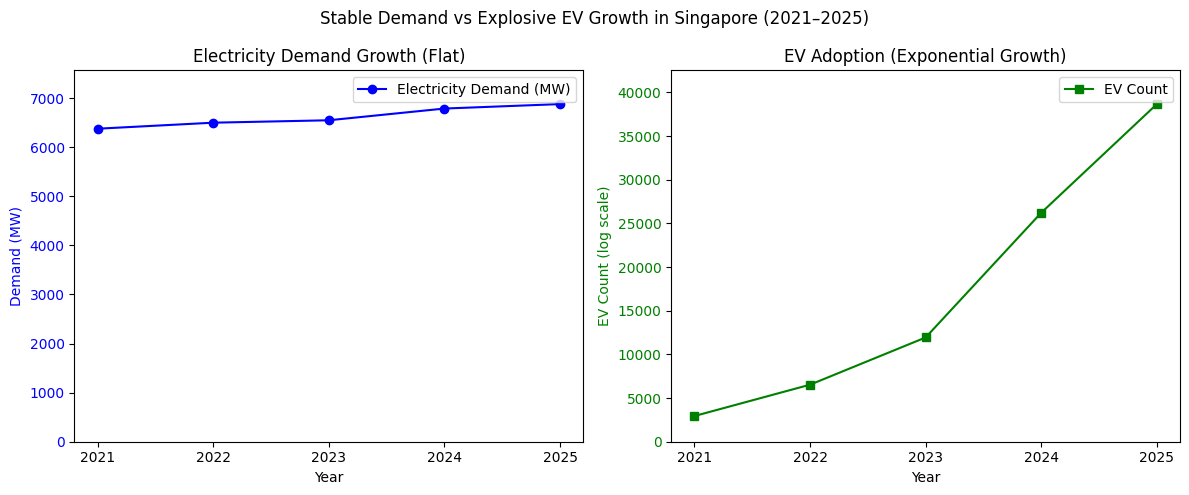

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Left: absolute MW vs EV count (raw)
axes[0].plot(df_yearly['Year'], df_yearly['Demand'], marker='o', color='blue', label='Electricity Demand (MW)')
axes[0].set_ylabel("Demand (MW)", color='blue')
axes[0].set_ylim(0, df_yearly['Demand'].max() * 1.1)  # start at 0
axes[0].set_title("Electricity Demand Growth (Flat)")
axes[0].tick_params(axis='y', labelcolor='blue')

axes[1].plot(df_yearly['Year'], df_yearly['EV Count'], marker='s', color='green', label='EV Count')
axes[1].set_ylabel("EV Count (log scale)", color='green')
axes[1].set_ylim(0, df_yearly['EV Count'].max() * 1.1)  # start at 0
axes[1].set_title("EV Adoption (Exponential Growth)")
axes[1].tick_params(axis='y', labelcolor='green')

for ax in axes:
    ax.set_xlabel("Year")
    ax.set_xticks(df_yearly['Year'].astype(int))  # ensure clean integer labels
    ax.legend()

plt.suptitle("Stable Demand vs Explosive EV Growth in Singapore (2021–2025)")
plt.tight_layout()
plt.show()